In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import cv2
from tensorflow.keras.models import Model
import zipfile
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE

# Dataset


In [ ]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
# base_path_drive = '/content/drive/MyDrive/LSMDWB_DataSet/'
BATCH_SIZE = 256
HEIGHT, WIDTH = 32, 32

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/ug26_3/ssl_ug4/datasets/cifar10.zip',"r") as zip_ref:
    zip_ref.extractall('dataset')
# with zipfile.ZipFile(base_path_drive+"Reduced_Test_Unbalanced_DataSet.zip","r") as zip_ref:
#     zip_ref.extractall('/content/Reduced_Test_Unbalanced_DataSet')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    # shuffle = False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

TOTAL_TRAIN_SAMPLES = train_generator.n
TOTAL_VAL_SAMPLES = test_generator.n
CLASSMAP = train_generator.class_indices
NUM_LAB = len(train_generator.class_indices.keys())

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


# Loss

In [ ]:
class InfoNCELoss:
  def __init__(self,tao=1):
    self.tao = tao
    pass
  def __call__(self , x, x_aug):
    u1 = x
    u2 = x_aug

    batch_size = u1.shape[0]
    norm_u1 = tf.math.l2_normalize(u1, axis=1)
    norm_u2 = tf.math.l2_normalize(u2, axis=1)
    sim12 = tf.reduce_sum(norm_u1 * norm_u2,axis=1)
    cross_corr1 = norm_u1 @ tf.transpose(norm_u1)
    cross_corr12 = norm_u1 @ tf.transpose(norm_u2)

    sim12_exp = tf.exp(sim12)
    cross_corr1_mask_exp = tf.reduce_sum(tf.exp(cross_corr1/self.tao) * (1-tf.eye(batch_size)),axis=-1)
    cross_corr12_mask_exp = tf.reduce_sum(tf.exp(cross_corr12/self.tao) * (1-tf.eye(batch_size)),axis=-1)
    denom = cross_corr1_mask_exp+cross_corr12_mask_exp+1e-9

    # print(sim12_exp)
    # print(denom)

    loss_val = tf.reduce_mean(-tf.math.log(sim12_exp/denom))
    return loss_val

In [ ]:
random_tensor1 = tf.ones(shape=(64, 256))
random_tensor2 = tf.eye(64)

In [ ]:
_ = InfoNCELoss()(random_tensor2,1-random_tensor2)
_

<tf.Tensor: shape=(), dtype=float32, numpy=4.901259>

# Model

In [ ]:
def get_functional_model():
  pre_trained_backbone =  tf.keras.applications.ResNet50(
      include_top=False ,
      weights=None,
      input_shape=(HEIGHT, WIDTH,3))

  inputs = pre_trained_backbone.input
  x1 = pre_trained_backbone.get_layer('conv3_block4_out').output
  x2 = tf.keras.layers.GlobalMaxPooling2D(name='gap_main')(x1)
  x2_bn = tf.keras.layers.BatchNormalization(name='bn_gap_main')(x2)
  x3 = tf.keras.layers.Dense(units=64,name='dense_1')(x2_bn)
  x3_bn = tf.keras.layers.BatchNormalization(name='bn_dense_1')(x3)
  # x4 = tf.keras.layers.Dense(NUM_LAB,activation=None,name='dense_2')(x3)
  # x5 = tf.keras.activations.softmax(x4)
  model = tf.keras.Model(inputs, [x3_bn])
  return model

In [ ]:
# _pre_trained_backbone =  tf.keras.applications.ResNet50(
#       include_top=False ,
#       weights='imagenet' ,
#       input_shape=(HEIGHT, WIDTH,3))
# tf.keras.utils.plot_model(_pre_trained_backbone, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def augment_images(images):
    """
    Augments a batch of images using TensorFlow.

    Args:
    - images: A tensor containing a batch of images with shape [batch_size, height, width, channels].

    Returns:
    - augmented_images: A tensor containing the augmented batch of images with the same shape as the input.
    """

    # Randomly apply augmentation techniques
    augmented_images = tf.image.random_flip_left_right(images)
    # augmented_images = tf.image.random_flip_up_down(augmented_images)
    augmented_images = tf.image.random_brightness(augmented_images, max_delta=0.2)
    augmented_images = tf.image.random_contrast(augmented_images, lower=0.5, upper=1.5)
    augmented_images = tf.image.random_saturation(augmented_images, lower=0.5, upper=1.5)
    augmented_images = tf.image.random_hue(augmented_images, max_delta=0.2)

    return augmented_images

In [ ]:
## Upstream
class CustomModelWrapperUpstream:
  def __init__(self, model):
    self.model = model
    self.meta = {
        'prev_model':model,
        'model':model,
        'history':None,
        'best_model':None,
        'stats':None
    }
    self.t_steps_per_epoch = TOTAL_TRAIN_SAMPLES//BATCH_SIZE
    self.v_steps_per_epoch = TOTAL_VAL_SAMPLES//BATCH_SIZE

## Upstream
  def compile(self, loss_objs:dict, optimizer_obj, metrics:dict):
    self.loss_objs, self.optimizer_obj, self.metrics = loss_objs, optimizer_obj, metrics

## Upstream
  @tf.function
  def train_single_batch(self, x, y):
    """
    shape of x -> (BATCH_SIZE, HEIGHT, WIDTH, CHANNEL)
    shape of y -> (BATCH_SIZE, ONEHOT)
    """
    aug_x = augment_images(x)

    with tf.GradientTape() as tape:
      pre_logits_branch1 = self.model(x, training=True)
      pre_logits_branch2 = self.model(aug_x, training=True)
      loss_value = self.loss_objs['info_nce'](pre_logits_branch1, pre_logits_branch2)

    grads = tape.gradient(loss_value , self.model.trainable_weights)
    self.optimizer_obj.apply_gradients(zip(grads, self.model.trainable_weights))
    return loss_value

## Upstream
  def train_single_epoch(self, data):
    losses = []
    pbar = tqdm(
        total=self.t_steps_per_epoch,
        position=0,
        leave=True,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    for step in range(1,self.t_steps_per_epoch+1):
      (x, y) = next(data)
      loss_value = self.train_single_batch(x,y)
      losses.append(loss_value)

      pbar.set_description(f"Training loss: {loss_value:.6f} for step: {step}")
      pbar.update()
    return losses


## Upstream
  def validate_single_epoch(self, data):
    losses = []
    for step in range(self.v_steps_per_epoch+1):
      (x, y) = next(data)
      aug_x = augment_images(x)

      pre_logits_branch1 = self.model(x, training=False)
      pre_logits_branch2 = self.model(aug_x, training=False)
      loss_value = self.loss_objs['info_nce'](pre_logits_branch1, pre_logits_branch2)
      losses.append(loss_value)

    return losses


## Upstream
  def fit(self, train_data, val_data, epochs):
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []

    # history['train_acc'] = []
    # history['val_acc'] = []

    # self.metrics['train_acc'].reset_states()
    # self.metrics['val_acc'].reset_states()


    for epoch in range(epochs):
      train_losses = self.train_single_epoch(train_data)
      val_losses   = self.validate_single_epoch(val_data)

      history['train_loss'].append(np.mean(train_losses))
      history['val_loss'].append(np.mean(val_losses))

      # train_metric_result    = self.metrics['train_acc'].result()
      # history['train_acc'].append(train_metric_result.numpy())
      # self.metrics['train_acc'].reset_states()


      # val_metric_result    = self.metrics['val_acc'].result()
      # history['val_acc'].append(val_metric_result.numpy())
      # self.metrics['val_acc'].reset_states()


      print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f' % (epoch, float(np.mean(train_losses)), float(np.mean(val_losses))))
      self.meta['prev_model'] = self.model
      self.meta['history'] = history

    self.meta['model'] = self.model
    history['model'] = self.model
    return history

In [ ]:
#Downstream
class CustomModelWrapperDownstream:
  def __init__(self, model):
    self.model = model
    self.t_steps_per_epoch = TOTAL_TRAIN_SAMPLES//BATCH_SIZE
    self.v_steps_per_epoch = TOTAL_VAL_SAMPLES//BATCH_SIZE

#Downstream
  def compile(self, loss_obj, optimizer_obj, metrics:dict):
    self.loss_obj, self.optimizer_obj, self.metrics = loss_obj, optimizer_obj, metrics

#Downstream
  @tf.function
  def train_single_batch(self, x, y):
    """
    shape of x -> (BATCH_SIZE, HEIGHT, WIDTH, CHANNEL)
    shape of y -> (BATCH_SIZE, ONEHOT)
    """

    with tf.GradientTape() as tape:
      y_pred = self.model(x, training=True)
      loss_value = self.loss_obj(y, y_pred)

    grads = tape.gradient(loss_value , self.model.trainable_weights)
    self.optimizer_obj.apply_gradients(zip(grads, self.model.trainable_weights))
    return y_pred , loss_value

#Downstream
  def train_single_epoch(self, data):
    losses = []
    pbar = tqdm(
        total=self.t_steps_per_epoch,
        position=0,
        leave=True,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    for step in range(1,self.t_steps_per_epoch+1):
      (x, y) = next(data)
      y_pred , loss_value = self.train_single_batch(x,y)
      losses.append(loss_value)

      self.metrics['train_acc'](y,  y_pred)

      pbar.set_description(f"Training loss: {loss_value:.6f} for step: {step}")
      pbar.update()
    return losses

#Downstream
  def validate_single_epoch(self, data):
    losses = []
    for step in range(self.v_steps_per_epoch+1):
      (x, y) = next(data)
      y_pred = self.model(x)
      loss_value = self.loss_obj(y,  y_pred)
      losses.append(loss_value)
      self.metrics['val_acc'](y,  y_pred)
    return losses

#Downstream
  def callback1(self,**kwargs):
    if float(kwargs['history']['val_acc'][-1]) > kwargs['threshold']:
      print("Desired Validation reached!!, ",kwargs['threshold'])
      return 1
    return 0

#Downstream
  def fit(self, train_data, val_data, epochs):
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []

    history['train_acc'] = []
    history['val_acc'] = []

    self.metrics['train_acc'].reset_states()
    self.metrics['val_acc'].reset_states()


    for epoch in range(epochs):
      train_losses = self.train_single_epoch(train_data)

      train_metric_result    = self.metrics['train_acc'].result()
      history['train_acc'].append(train_metric_result.numpy())
      self.metrics['train_acc'].reset_states()

      val_losses   = self.validate_single_epoch(val_data)

      val_metric_result    = self.metrics['val_acc'].result()
      history['val_acc'].append(val_metric_result.numpy())
      self.metrics['val_acc'].reset_states()

      history['train_loss'].append(np.mean(train_losses))
      history['val_loss'].append(np.mean(val_losses))

      print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f,\
         Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(train_losses)), float(np.mean(val_losses)),
                                                            float(train_metric_result), float(val_metric_result)))

      if self.callback1(history=history,threshold=0.82)==1:
        break;

    history['model'] = self.model
    return history

# Compilation And Training

## Upstream

In [ ]:
model_wrapper_up = CustomModelWrapperUpstream(get_functional_model())

In [ ]:
model_wrapper_up.compile(
    loss_objs = {'info_nce':InfoNCELoss(1.5)},
    optimizer_obj=  tf.keras.optimizers.Adam(learning_rate = 0.2),
    metrics = None
)

In [ ]:
history_up = model_wrapper_up.fit(
    train_generator,
    test_generator,
    epochs=40)

Training loss: 5.291056 for step: 195: 100%|██████████| 195/195 



 Epoch 0: Train loss: 5.3132  Validation Loss: 5.4746


Training loss: 5.268033 for step: 195: 100%|██████████| 195/195 



 Epoch 1: Train loss: 5.2726  Validation Loss: 5.3602


Training loss: 5.262078 for step: 195: 100%|██████████| 195/195 



 Epoch 2: Train loss: 5.2631  Validation Loss: 5.3527


Training loss: 5.260731 for step: 195: 100%|██████████| 195/195 



 Epoch 3: Train loss: 5.2573  Validation Loss: 5.4104


Training loss: 5.256469 for step: 195: 100%|██████████| 195/195 



 Epoch 4: Train loss: 5.2526  Validation Loss: 5.3508


Training loss: 5.253285 for step: 195: 100%|██████████| 195/195 



 Epoch 5: Train loss: 5.2486  Validation Loss: 5.3362


Training loss: 5.250253 for step: 195: 100%|██████████| 195/195 



 Epoch 6: Train loss: 5.2470  Validation Loss: 5.3087


Training loss: 5.248827 for step: 195: 100%|██████████| 195/195 



 Epoch 7: Train loss: 5.2456  Validation Loss: 5.3143


Training loss: 5.250260 for step: 195: 100%|██████████| 195/195 



 Epoch 8: Train loss: 5.2445  Validation Loss: 5.2721


Training loss: 5.248055 for step: 195: 100%|██████████| 195/195 



 Epoch 9: Train loss: 5.2442  Validation Loss: 5.2694


Training loss: 5.255298 for step: 195: 100%|██████████| 195/195 



 Epoch 10: Train loss: 5.2445  Validation Loss: 5.2814


Training loss: 5.251002 for step: 195: 100%|██████████| 195/195 



 Epoch 11: Train loss: 5.2440  Validation Loss: 5.2844


Training loss: 5.247777 for step: 195: 100%|██████████| 195/195 



 Epoch 12: Train loss: 5.2435  Validation Loss: 5.2516


Training loss: 5.251554 for step: 195: 100%|██████████| 195/195 



 Epoch 13: Train loss: 5.2432  Validation Loss: 5.2704


Training loss: 5.247478 for step: 195: 100%|██████████| 195/195 



 Epoch 14: Train loss: 5.2427  Validation Loss: 5.2957


Training loss: 5.248230 for step: 195: 100%|██████████| 195/195 



 Epoch 15: Train loss: 5.2425  Validation Loss: 5.2988


Training loss: 5.247087 for step: 195: 100%|██████████| 195/195 



 Epoch 16: Train loss: 5.2424  Validation Loss: 5.2704


Training loss: 5.248003 for step: 195: 100%|██████████| 195/195 



 Epoch 17: Train loss: 5.2423  Validation Loss: 5.2788


Training loss: 5.248136 for step: 195: 100%|██████████| 195/195 



 Epoch 18: Train loss: 5.2425  Validation Loss: 5.2633


Training loss: 5.248399 for step: 195: 100%|██████████| 195/195 



 Epoch 19: Train loss: 5.2422  Validation Loss: 5.2499


Training loss: 5.249194 for step: 195: 100%|██████████| 195/195 



 Epoch 20: Train loss: 5.2420  Validation Loss: 5.2928


Training loss: 5.247062 for step: 195: 100%|██████████| 195/195 



 Epoch 21: Train loss: 5.2422  Validation Loss: 5.2635


Training loss: 5.248502 for step: 195: 100%|██████████| 195/195 



 Epoch 22: Train loss: 5.2412  Validation Loss: 5.2611


Training loss: 5.246596 for step: 195: 100%|██████████| 195/195 



 Epoch 23: Train loss: 5.2411  Validation Loss: 5.2738


Training loss: 5.246051 for step: 195: 100%|██████████| 195/195 



 Epoch 24: Train loss: 5.2413  Validation Loss: 5.2828


Training loss: 5.249076 for step: 195: 100%|██████████| 195/195 



 Epoch 25: Train loss: 5.2410  Validation Loss: 5.2534


Training loss: 5.246573 for step: 195: 100%|██████████| 195/195 



 Epoch 26: Train loss: 5.2417  Validation Loss: 5.2667


Training loss: 5.245518 for step: 195: 100%|██████████| 195/195 



 Epoch 27: Train loss: 5.2411  Validation Loss: 5.2701


Training loss: 5.246222 for step: 195: 100%|██████████| 195/195 



 Epoch 28: Train loss: 5.2410  Validation Loss: 5.2787


Training loss: 5.245871 for step: 195: 100%|██████████| 195/195 



 Epoch 29: Train loss: 5.2407  Validation Loss: 5.2873


Training loss: 5.246506 for step: 195: 100%|██████████| 195/195 



 Epoch 30: Train loss: 5.2411  Validation Loss: 5.2972


Training loss: 5.247083 for step: 195: 100%|██████████| 195/195 



 Epoch 31: Train loss: 5.2410  Validation Loss: 5.2971


Training loss: 5.246701 for step: 195: 100%|██████████| 195/195 



 Epoch 32: Train loss: 5.2407  Validation Loss: 5.2940


Training loss: 5.245359 for step: 195: 100%|██████████| 195/195 



 Epoch 33: Train loss: 5.2409  Validation Loss: 5.2689


Training loss: 5.245159 for step: 195: 100%|██████████| 195/195 



 Epoch 34: Train loss: 5.2406  Validation Loss: 5.2955


Training loss: 5.245360 for step: 195: 100%|██████████| 195/195 



 Epoch 35: Train loss: 5.2401  Validation Loss: 5.3061


Training loss: 5.249910 for step: 195: 100%|██████████| 195/195 



 Epoch 36: Train loss: 5.2401  Validation Loss: 5.2679


Training loss: 5.244957 for step: 195: 100%|██████████| 195/195 



 Epoch 37: Train loss: 5.2402  Validation Loss: 5.2703


Training loss: 5.245573 for step: 195: 100%|██████████| 195/195 



 Epoch 38: Train loss: 5.2398  Validation Loss: 5.2630


Training loss: 5.245143 for step: 195: 100%|██████████| 195/195 



 Epoch 39: Train loss: 5.2398  Validation Loss: 5.2966


In [ ]:
trained_model_up = model_wrapper_up.meta['model']

In [ ]:
# trained_model_up.save('/content/drive/MyDrive/ug26_3/ssl_ug4/models/simclr_1.h5')
# trained_model_up = tf.keras.models.load_model('/content/drive/MyDrive/ug26_3/ssl_ug4/models/simclr_0.h5')

# Evaluating Upstream Task

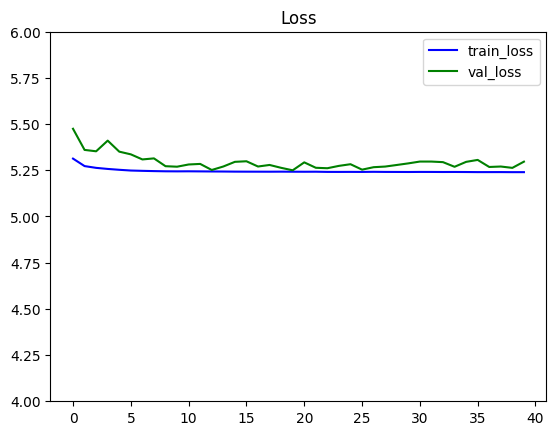

In [ ]:
def plot_metrics(history,metric_name, title, ylims=(0,1)):
    plt.title(title)
    plt.ylim(ylims[0],ylims[1])
    plt.plot(history['train_' + metric_name],color='blue',label='train_' +metric_name)
    plt.plot(history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()
    plt.show()

plot_metrics(model_wrapper_up.meta['history'],metric_name='loss', title="Loss",ylims=(4,6))

# Neural Representation

In [ ]:
_pre_logit_maps = None
_pre_logit_maps_aug = None
_labels = None

for _ in range(2):
  _x,_y = next(train_generator)
  _x_aug = augment_images(_x)

  _pre_logit = trained_model_up(_x)
  _pre_logit_aug = trained_model_up(_x_aug)

  if _pre_logit_maps is not None:
    _pre_logit_maps = np.concatenate([_pre_logit_maps,_pre_logit.numpy()],axis=0)
    _pre_logit_maps_aug = np.concatenate([_pre_logit_maps_aug,_pre_logit_aug.numpy()],axis=0)
    _labels = np.concatenate([_labels,np.argmax(_y,axis=-1)],axis=0)
  else:
    _pre_logit_maps = _pre_logit.numpy()
    _pre_logit_maps_aug = _pre_logit_aug.numpy()
    _labels = np.argmax(_y,axis=-1)

In [ ]:
norm_lambda = lambda _ :tf.math.l2_normalize(_, axis=1).numpy()     #( _-np.min(_,0))/(np.max(_,0)-np.min(_,0)+1e-9)
meannorm_lambda = lambda _ : (_ - np.mean(_,axis=0))/(np.std(_,axis=0)+1e-9)    #( _-np.min(_,0))/(np.max(_,0)-np.min(_,0)+1e-9)

In [ ]:
# arr = np.array([[1.,2.,1.],[2.,3.,4.],[5.,6.,7.],[6.,7.,8.]])
arr = np.random.uniform(0, 1, size=(10, 10))/100000000

In [ ]:
np.mean(arr,axis=0)

array([4.74708921e-09, 4.57761304e-09, 5.78388451e-09, 4.69273687e-09,
       4.13609822e-09, 4.90131955e-09, 4.24699900e-09, 4.98918819e-09,
       5.78397021e-09, 5.41414251e-09])

In [ ]:
arr_ = meannorm_lambda(arr)

In [ ]:
np.matmul(arr_.T,arr_)/10

array([[ 0.57985469,  0.08981818, -0.13990887, -0.04639826, -0.1547638 ,
        -0.18033053, -0.15832936,  0.16559535,  0.25301883,  0.22661142],
       [ 0.08981818,  0.5550788 , -0.30372584,  0.21423691,  0.02444561,
        -0.39902338,  0.07176538, -0.21583707,  0.20863666, -0.07621161],
       [-0.13990887, -0.30372584,  0.58563477, -0.18159421, -0.36666738,
         0.35033536, -0.18343054,  0.17187347, -0.14851962,  0.15945532],
       [-0.04639826,  0.21423691, -0.18159421,  0.58429847,  0.09295129,
        -0.01093667, -0.1760668 ,  0.06872483, -0.12690731,  0.2064959 ],
       [-0.1547638 ,  0.02444561, -0.36666738,  0.09295129,  0.57759257,
        -0.00327474,  0.36528135, -0.23152803, -0.07132244, -0.20992582],
       [-0.18033053, -0.39902338,  0.35033536, -0.01093667, -0.00327474,
         0.56747801, -0.08150519,  0.31530084, -0.31641145,  0.09793824],
       [-0.15832936,  0.07176538, -0.18343054, -0.1760668 ,  0.36528135,
        -0.08150519,  0.55147496, -0.316395  

In [ ]:
arr.shape

(4, 3)

Same

In [ ]:
_trunc_pre_logit_maps = norm_lambda(_pre_logit_maps)
_trunc_pre_logit_maps_aug = norm_lambda(_pre_logit_maps_aug)

# _trunc_pre_logit_maps = meannorm_lambda(_pre_logit_maps)
# _trunc_pre_logit_maps_aug = meannorm_lambda(_pre_logit_maps_aug)

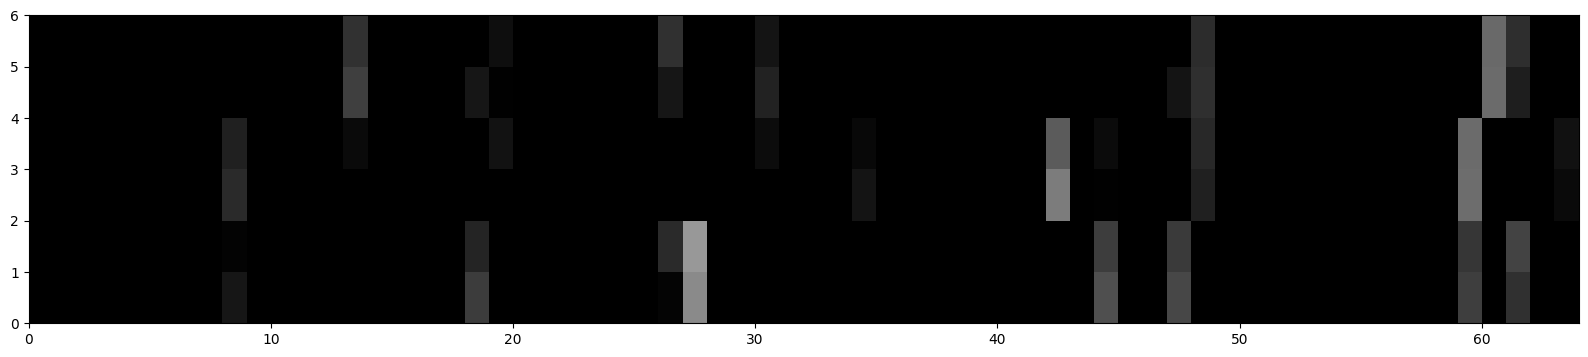

In [ ]:
up_indx = 3
fig, ax = plt.subplots(figsize=(20, 4))
cmap = plt.get_cmap("gray")

for indx in range(up_indx):
  for _j in range(_trunc_pre_logit_maps[indx].shape[0]):
    ax.add_patch(plt.Rectangle((_j, indx*2), 1, 1, fc=cmap(_trunc_pre_logit_maps[indx][_j])))
    ax.add_patch(plt.Rectangle((_j, indx*2+1), 1, 1, fc=cmap(_trunc_pre_logit_maps_aug[indx][_j])))

ax.set_ylim(0,2*up_indx)
ax.set_xlim(0,64)
plt.show()

In [ ]:
_num_examples = _trunc_pre_logit_maps.shape[0]

feat_corr_matrix = np.matmul(meannorm_lambda(_trunc_pre_logit_maps).T, meannorm_lambda(_trunc_pre_logit_maps_aug))/_num_examples

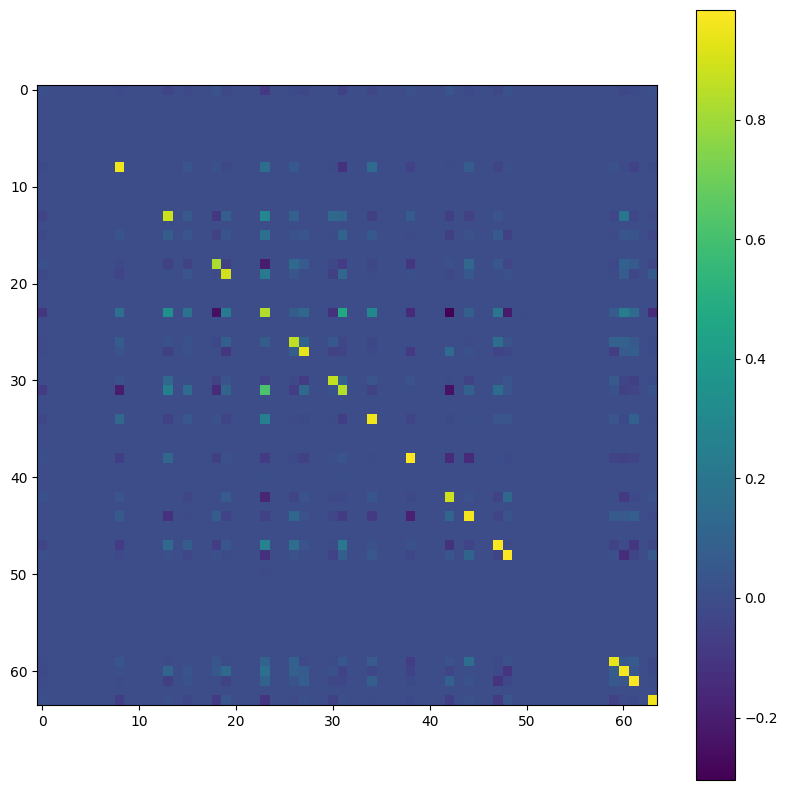

In [ ]:
plt.figure(figsize=(10, 10))
plt.get_cmap("gray")
plt.imshow(feat_corr_matrix)
plt.colorbar()
plt.show()

In [ ]:
bt_loss_diag = np.sum(((np.eye(64) - feat_corr_matrix)*np.eye(64))**2)
bt_loss_nondiag = np.sum(((np.eye(64) - feat_corr_matrix)*(1-np.eye(64)))**2)
print(f"Diag Loss {bt_loss_diag}, NonDiag Loss {bt_loss_nondiag}")

Diag Loss 45.08134836577477, NonDiag Loss 3.332588084822098


Different

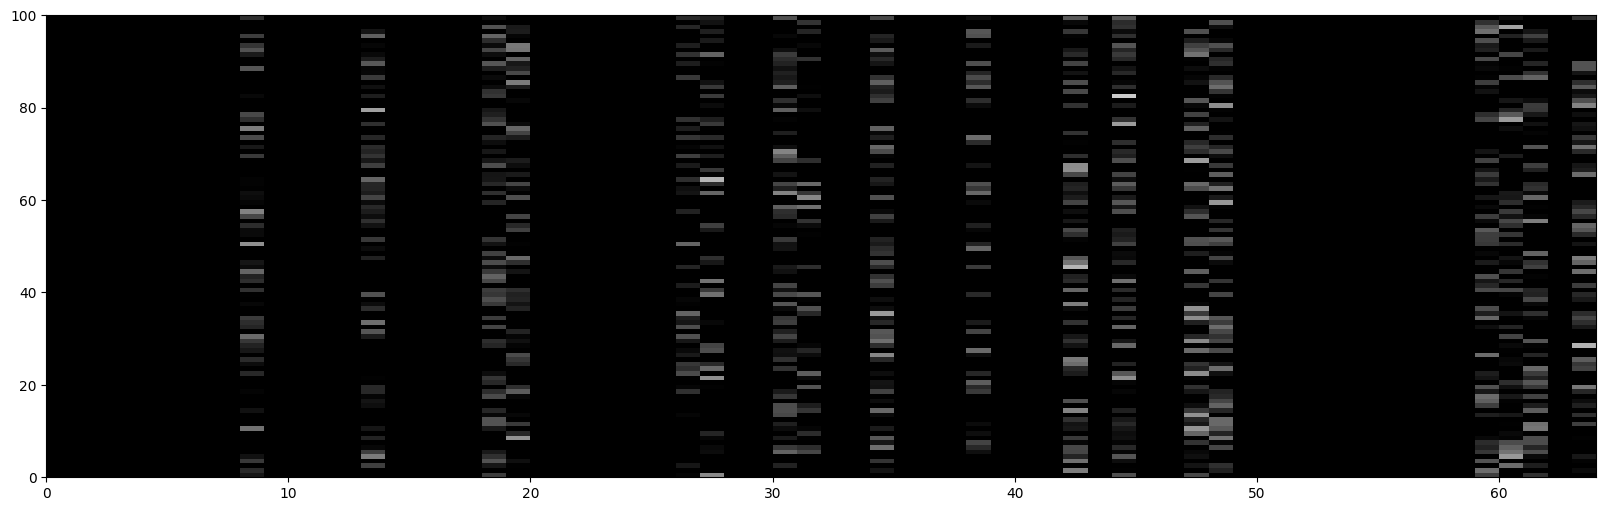

In [ ]:
up_indx = 100
fig, ax = plt.subplots(figsize=(20, 6))
cmap = plt.get_cmap("gray")

for indx in range(up_indx):
  for _j in range(_trunc_pre_logit_maps[indx].shape[0]):
    ax.add_patch(plt.Rectangle((_j, indx), 1, 1, fc=cmap(_trunc_pre_logit_maps[indx][_j])))
    # ax.add_patch(plt.Rectangle((_j, indx*2+1), 1, 1, fc=cmap(_trunc_pre_logit_maps_aug[indx][_j])))

ax.set_ylim(0,up_indx)
ax.set_xlim(0,64)
plt.show()

In [ ]:
_trunc_pre_logit_maps.shape

(512, 64)

In [ ]:
for c in range(10):
  _org = _trunc_pre_logit_maps[_labels==c]
  _aug = _trunc_pre_logit_maps_aug[_labels==c]

  print(f"Class :{c}")
  print(f"Avg Correlation Same:  {np.mean(np.sum(_org*_aug,axis=-1))}")
  print(f"Avg Correlation Different:  {np.mean(np.sum(_org*_aug[::-1],axis=-1))}")

Class :0
Avg Correlation Same:  0.8997336626052856
Avg Correlation Different:  0.060408417135477066
Class :1
Avg Correlation Same:  0.9317629337310791
Avg Correlation Different:  0.06252837926149368
Class :2
Avg Correlation Same:  0.905829906463623
Avg Correlation Different:  0.08466054499149323
Class :3
Avg Correlation Same:  0.9262474179267883
Avg Correlation Different:  0.0035637160763144493
Class :4
Avg Correlation Same:  0.8942828178405762
Avg Correlation Different:  0.047716785222291946
Class :5
Avg Correlation Same:  0.9176486730575562
Avg Correlation Different:  0.10816522687673569
Class :6
Avg Correlation Same:  0.8954532742500305
Avg Correlation Different:  0.16474665701389313
Class :7
Avg Correlation Same:  0.9101991057395935
Avg Correlation Different:  0.09682463109493256
Class :8
Avg Correlation Same:  0.8984616994857788
Avg Correlation Different:  0.17165300250053406
Class :9
Avg Correlation Same:  0.9206616282463074
Avg Correlation Different:  0.14178691804409027


## Downstream

In [ ]:
model_wrapper = CustomModelWrapper(get_functional_model())

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model_wrapper.compile(
    loss_obj = tf.keras.losses.CategoricalCrossentropy(),
    optimizer_obj=  tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = {
        'train_acc':tf.keras.metrics.CategoricalAccuracy(),
        'val_acc':tf.keras.metrics.CategoricalAccuracy()
    }
)

In [ ]:
history = model_wrapper.fit(
    train_generator,
    test_generator,
    epochs=10)

In [ ]:
trained_model = model_wrapper.model

In [ ]:
# trained_model.save('/content/drive/MyDrive/ug26_1/models/nothing_dense.h5')
# trained_model = tf.keras.models.load_model('/content/drive/MyDrive/ug26_1/models/nothing_dense.h5')

In [ ]:
# trained_model.summary()

# Evaluation

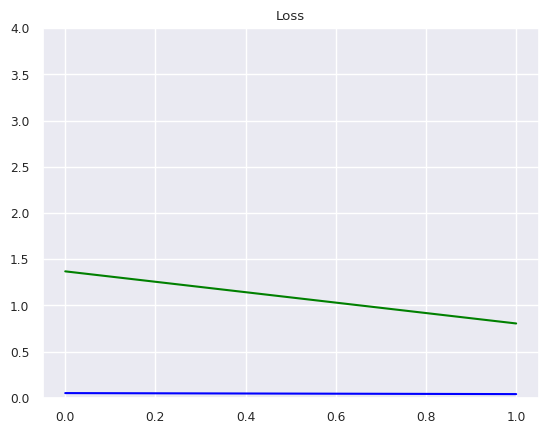

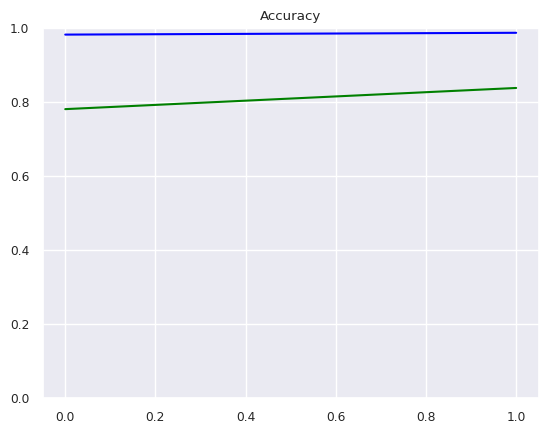

In [ ]:
def plot_metrics(metric_name, title, ylim=1):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history['train_' + metric_name],color='blue',label='train_' +metric_name)
    plt.plot(history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.show()

plot_metrics(metric_name='loss', title="Loss",ylim=4)
plot_metrics(metric_name='acc', title="Accuracy")

In [ ]:
x_test, y_test = (next(test_generator))
for i in range(TOTAL_VAL_SAMPLES//BATCH_SIZE):
 x_test_temp, y_test_temp = (next(test_generator));
 x_test = np.concatenate((x_test,x_test_temp));
 y_test = np.concatenate((y_test,y_test_temp));

In [ ]:
# Prediction on test data
y_pred = trained_model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

63/63 [==============================] - 1s 19ms/step


<Axes: >

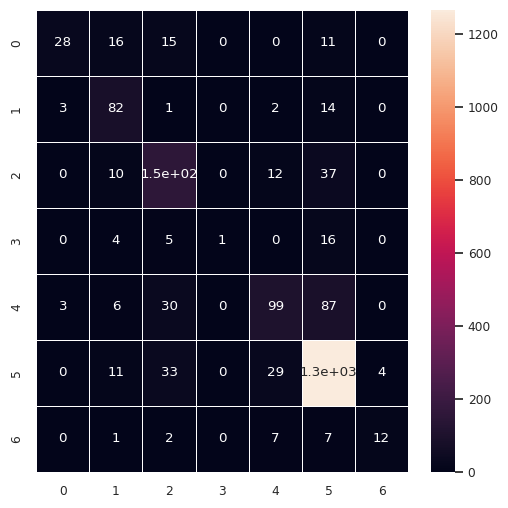

In [ ]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=0.8)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

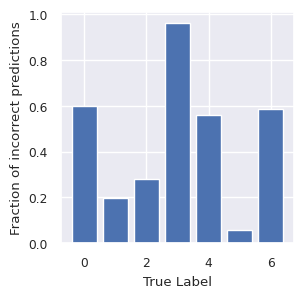

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(3,3))
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [ ]:
cm = confusion_matrix(tf.argmax(y_test,axis=-1), tf.argmax(y_pred,axis=-1))

precision = (tf.convert_to_tensor([float(cm[x][x]) for x in range(NUM_LAB)])/tf.cast(tf.reduce_sum(cm,axis=0),dtype=tf.float32)).numpy()
recall = (tf.convert_to_tensor([float(cm[x][x]) for x in range(NUM_LAB)])/tf.cast(tf.reduce_sum(cm,axis=1),dtype=tf.float32)).numpy()
f1 = 2*precision*recall/(precision+recall+1e-9)
acc = 1-incorr_fraction

mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)
mean_acc = np.mean(acc)

print("Classwise Metrics")
print(precision)
print(recall)
print(f1)
print(acc)

print("Mean Metrics")
print("mean_precision: ",mean_precision)
print("mean_recall: ",mean_recall)
print("mean_f1: ",mean_f1)
print("mean_acc: ",mean_acc)

Classwise Metrics
[0.8235294  0.63076925 0.6371308  1.         0.66442955 0.88038945
 0.75      ]
[0.4        0.8039216  0.7190476  0.03846154 0.44       0.9426657
 0.41379312]
[0.5384615  0.7068966  0.6756152  0.07407407 0.5294118  0.9104639
 0.53333336]
[0.4        0.80392157 0.71904762 0.03846154 0.44       0.94266567
 0.4137931 ]
Mean Metrics
mean_precision:  0.7694641
mean_recall:  0.53684133
mean_f1:  0.56689376
mean_acc:  0.5368413576356239


# GradCam

In [ ]:
def visualize_class_activation_map(model, img_path, output_path,layer_name, thr=0.0, verbose=True):
  original_img = cv2.imread(img_path, 1)
  original_img = cv2.resize(original_img, (224, 224))
  width, height, _ = original_img.shape

  img = tf.expand_dims(original_img,axis=0)

  conv_outputs = (model.get_layer(layer_name).output)
  get_output = tf.keras.backend.function([model.layers[0].input], [conv_outputs])
  [conv_outputs] = get_output([img])
  conv_outputs = conv_outputs[0, :, :, :]

  #Create the class activation map.
  cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])

  for i in range(conv_outputs.shape[2]):
    cam += 1.0 * conv_outputs[:, :, i]

  cam /= np.max(cam)
  try:
    cam = cam.numpy()
  except:
    pass
  cam = cv2.resize(cam, (height, width))
  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam < thr)] = 0
  cam_img = heatmap#*0.5 #+ original_img

  cam_img = cv2.resize(cam_img, (224, 224))
  cv2.imwrite(output_path, cam_img)

  im = Image.open(img_path)
  if verbose:
    plt.figure(figsize=(5, 5))
    im.resize((224, 224))
    plt.imshow(np.array(im))
    plt.show()


  im = Image.open(output_path)
  if verbose:
    plt.figure(figsize=(5, 5))
    im.resize((224, 224))
    plt.imshow(np.array(cam_img))
    plt.colorbar()
    plt.show()

  return cam, cam_img,im

In [ ]:
def visualize_saliency_map(model, img_path, classname):
  label = CLASSMAP[classname]
  y = tf.cast(tf.expand_dims(tf.one_hot(label,depth=7),axis=0),dtype=tf.float32)
  x = tf.convert_to_tensor(np.expand_dims(np.array(Image.open(img_path)),axis=0),dtype=tf.float32)
  # truncated_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)
  with tf.GradientTape() as tape:
    tape.watch(x)
    tape.watch(y)
    y_pred = model(x)
    # feature_map =
    L = tf.keras.losses.CategoricalCrossentropy()(y, y_pred)
  grad = tape.gradient(L , x)

  grayscale_tensor = tf.reduce_sum(tf.abs(grad), axis=-1)
  normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
       )
  normalized_tensor = tf.squeeze(normalized_tensor)
  grad_numpy_norm = normalized_tensor.numpy()
  return grad_numpy_norm

In [ ]:
# tf.math.maximum([1,-3,4,5],0)

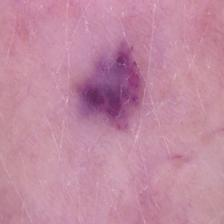

In [ ]:
target_img_path = '/content/Reduced_Test_Unbalanced_DataSet/vasc/ISIC_0027563.jpg'
og_img = Image.open(target_img_path)
og_img

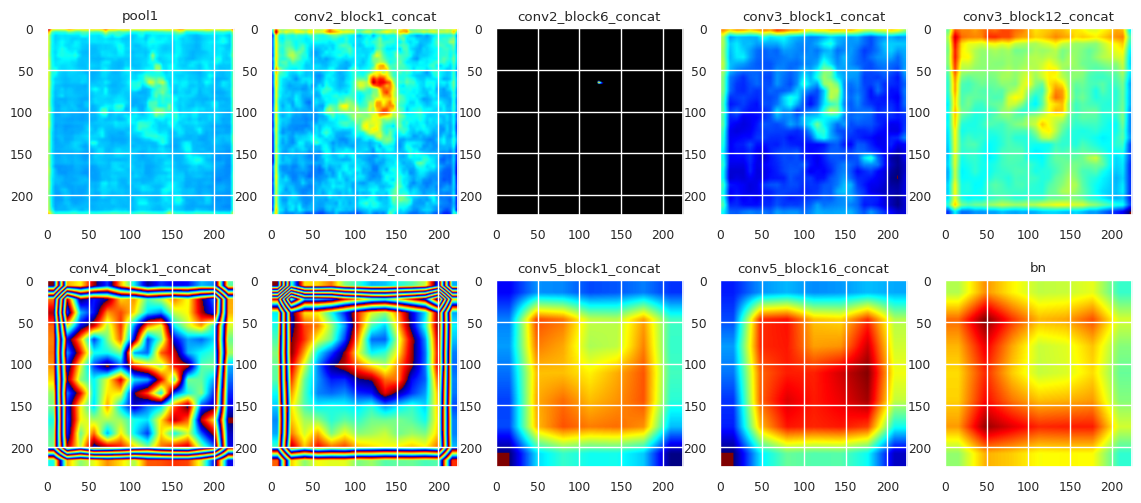

In [ ]:
layers = [
    'pool1',
    'conv2_block1_concat',
    'conv2_block6_concat',
    'conv3_block1_concat',
    'conv3_block12_concat',
    'conv4_block1_concat',
    'conv4_block24_concat',
    'conv5_block1_concat',
    'conv5_block16_concat',
    'bn',
]

grad_ims = {}
for layer in layers:
  cam, cam_img,im = visualize_class_activation_map(
      trained_model,
      target_img_path,
      'cam.png',
      layer,
      thr=0.0,
      verbose=False);
  grad_ims[layer]=im.convert('RGB')


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 6))
for i in range(len(layers)):
  axes[i//5, i%5].imshow(grad_ims[layers[i]])
  axes[i//5, i%5].set_title(layers[i])

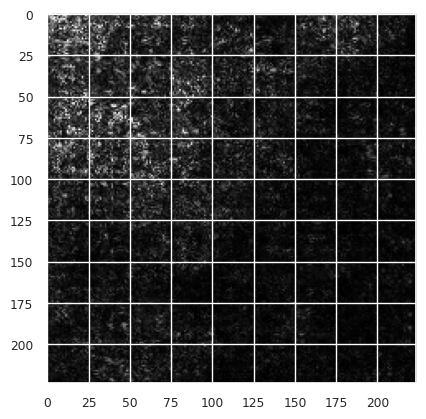

In [ ]:
g = visualize_saliency_map(trained_model,target_img_path,target_img_path.split('/')[-2])
# Saliency
plt.imshow(g*2,cmap='gray')

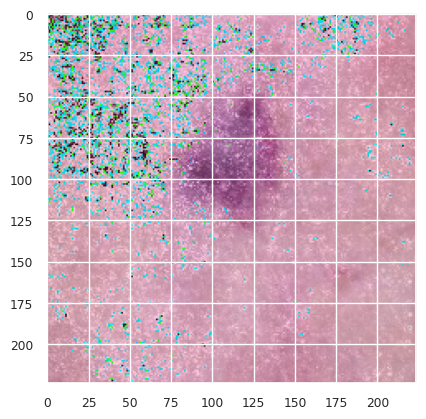

In [ ]:
# Saliency on real image
plt.imshow(np.expand_dims(g,axis=-1)*2 + np.array(og_img),cmap='gray')

# TSNE Projection

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
trained_model.summary()

In [ ]:
feature_extractor = tf.keras.Model(trained_model.input, trained_model.get_layer('global_max_pooling2d').output)
features = feature_extractor(x_test)
tsne_projections = TSNE(random_state=42).fit_transform(features)

In [ ]:
scatter(tsne_projections,y_true);

NameError: name 'y_true' is not defined